In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import time
import gc
import copy

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc


In [2]:
#file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]
file_numbers = [1 ,2]
structure = {f'dataset_{file_number}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for file_number in file_numbers}


def preprocess(data):
    #data shape: (trials, time, neurons)
    trials, time, num_neurons = data.shape
    z = np.zeros_like(data)

    for neuron in range(num_neurons):
        for t in range(time):
            vals = data[:, t, neuron]  #this is all the data for given neuron at given time point
            std = np.std(vals)
            if std > 1e-6:
                z[:, t, neuron] = (vals - np.mean(vals)) / std    #zscore if there is a stdev
            else:
                z[:, t, neuron] = np.median(vals)   #returnt the median value otherwise  (median rather than mean in case of large variability in a singel point)

    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z


def get_data(file_number):
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    data = pickle.load(open(file_path, 'rb'))
  
    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted ==0)[0]
    left_indices_agg = np.where((omitted ==0) & (attend_01 == 0) & (label_left != label_right))[0]  #indices of agg where left
    right_indices_agg = np.where((omitted ==0) & (attend_01 == 1) & (label_left != label_right))[0]  #indices of agg where right

    left_attleft = data['SP'][0][0][left_indices_agg]
    left_attright = data['SP'][0][0][right_indices_agg]

    right_attleft = data['SP'][0][1][left_indices_agg]
    right_attright = data['SP'][0][1][right_indices_agg]

    att_attleft = data['SP'][0][2][left_indices_agg]
    att_attright = data['SP'][0][2][right_indices_agg]


    num_trials_left, num_samples, num_neurons = left_attleft.shape
    num_trials_right = left_attright.shape[0]
    num_neurons_attention = 80

    return left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright, num_trials_left, num_trials_right, num_samples, num_neurons, num_neurons_attention


data_left_attleft = []
data_left_attright = []
data_right_attleft = []
data_right_attright = []
data_att_attleft = []
data_att_attright = []

def collect_data():
    for file_number in file_numbers:
        left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright, num_trials_left, num_trials_right, num_samples, num_neurons, num_neurons_attention = get_data(file_number)
        data_left_attleft.append(left_attleft)
        data_left_attright.append(left_attright)
        data_right_attleft.append(right_attleft)   
        data_right_attright.append(right_attright)
        data_att_attleft.append(att_attleft)
        data_att_attright.append(att_attright)

    return data_left_attleft, data_left_attright, data_right_attleft, data_right_attright, data_att_attleft, data_att_attright

   


In [3]:
data_left_attleft, data_left_attright, data_right_attleft, data_right_attright, data_att_attleft, data_att_attright = collect_data()

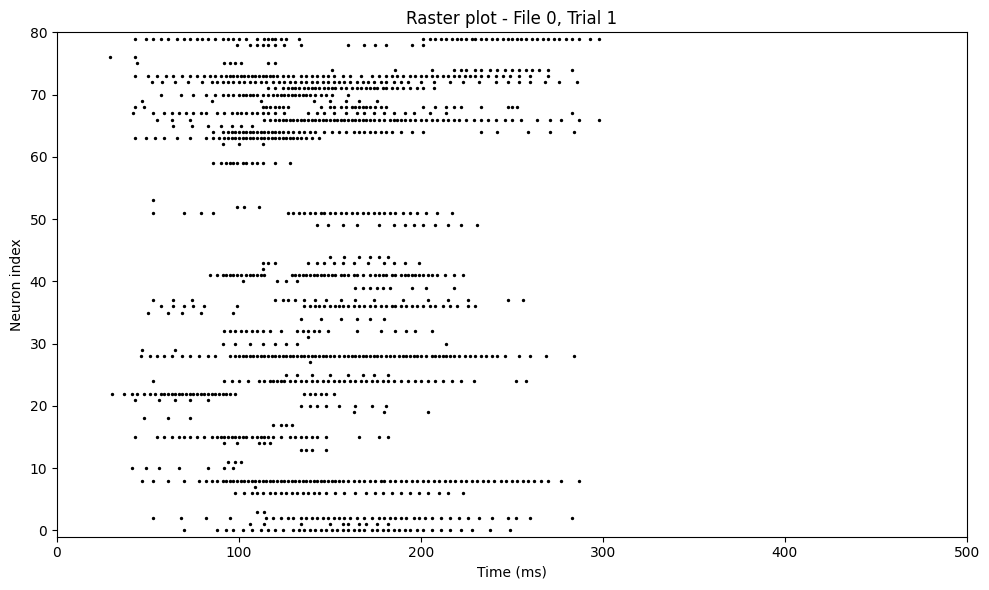

In [4]:
def plot_raster(data, file_idx = 0, trial_idx = 0, title='Raster Plot', neuron_subset=None):
    trial_data = data[file_idx][trial_idx]

    time, num_neurons = trial_data.shape
    fig, ax = plt.subplots(figsize=(10, 6))

    if neuron_subset is not None:
        trial_data = trial_data[:, neuron_subset]
        num_neurons = len(neuron_subset)

    for neuron_idx in range(num_neurons):
        spike_times = np.where(trial_data[:, neuron_idx] > 0)[0]
        ax.scatter(spike_times, np.full_like(spike_times, neuron_idx), s=2, color='black')

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron index')
    ax.set_title(title)
    ax.set_ylim(-1, num_neurons)
    ax.set_xlim(0, time)
    plt.title(title + f' - File {file_idx}, Trial {trial_idx}')
    plt.tight_layout()
    plt.show()


plot_raster(data_att_attleft, file_idx = 0, trial_idx = 1, title=f'Raster plot')


In [5]:
def plot_firing_rates(data, file_idx=0):
    plot_data = data[file_idx] 
    trials, time, neurons = plot_data.shape
    
    #find mean firing rate per neuron across trials and time
    firing_rates = plot_data.mean(axis=(0, 1))  # shape: (neurons,)
    
    #histogram of firing rates
    plt.figure(figsize=(10, 5))
    plt.hist(firing_rates, bins=30, color='black', alpha=0.7)
    plt.xlabel("Mean firing rate (spikes per timestep)")
    plt.ylabel("Number of neurons")
    plt.title(f"Firing rate distribution (File {file_idx})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #sorted bar plot of firing rates
    sorted_rates = np.sort(firing_rates)[::-1]
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(neurons), sorted_rates, color='black')
    plt.xlabel("Neuron (sorted by activity)")
    plt.ylabel("Mean firing rate")
    plt.title(f"Sorted neuron activity (File {file_idx})")
    plt.tight_layout()
    plt.show()
    
    return firing_rates


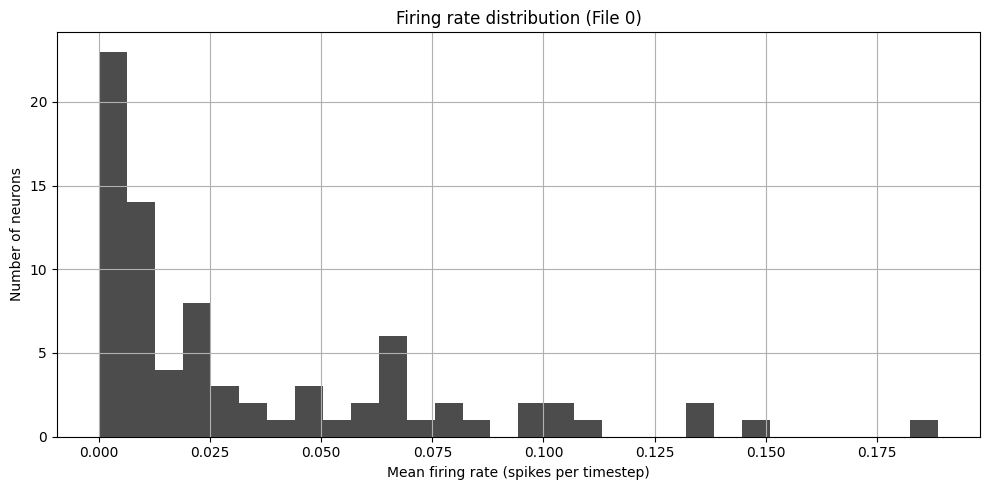

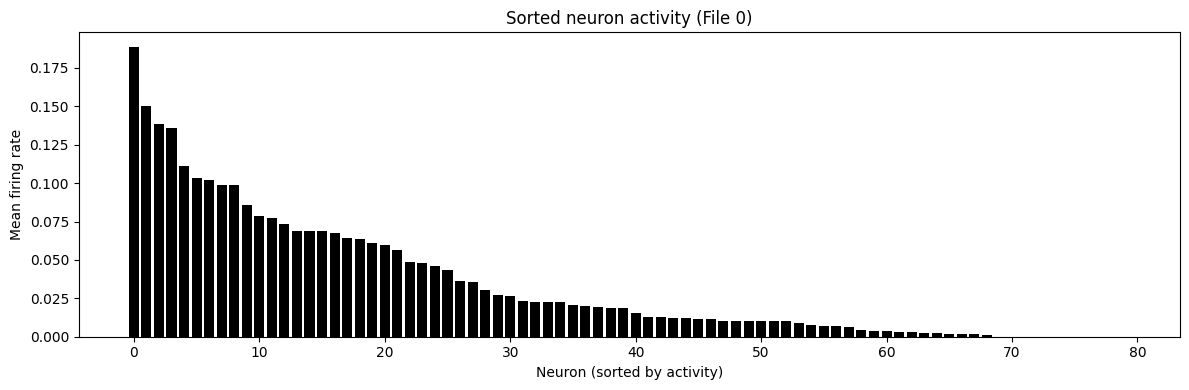

In [6]:
firing_rates = plot_firing_rates(data_att_attleft, file_idx=0)


we therefore should look to model just the meaningful subset of neurons - wish for the model to reject the inactive ones. 

In [7]:
# full_data_left = np.vstack(data_left)
# full_data_right = np.vstack(data_right)
# full_data_attention = np.vstack(data_attention)

In [8]:
#want to stack the data to form X or inputs and y for output neuron activity

def prep_data(data_in, data_out, firing_threshold = 0.01):
    trials, time, input_neurons = data_in.shape
    _, _, output_neurons = data_out.shape

    #reshaping the data
    relevant_input = data_in[:, 100:350, :] 
    relevant_output = data_out[:, 100:350, :]

    X = relevant_input.reshape(-1, input_neurons)  #shape: (trials * time, input_neurons)
    Y = relevant_output.reshape(-1, output_neurons)  #shape: (trials * time, output_neurons)
    print(X.shape, Y.shape)

    mean_rates = Y.mean(axis = 0)
    most_active = np.where(mean_rates > firing_threshold)[0]
    least_active = np.where(mean_rates <= firing_threshold)[0]

    return X, Y, most_active, least_active


def train_logistic_regression(X, y, C = 1.0):
    model = LogisticRegression(
        penalty = 'l1',
        solver = 'liblinear',
        C = C,
        class_weight = 'balanced',
        max_iter=1000)
    model.fit(X, y)
    return model
#will run this on the training data


(117000, 160) (117000, 80)
Accuracy on test set for neuron 0: 0.64
Spike rate in test set: 0.100
              precision    recall  f1-score   support

         0.0      0.954     0.628     0.758     21051
         1.0      0.180     0.731     0.289      2349

    accuracy                          0.638     23400
   macro avg      0.567     0.680     0.523     23400
weighted avg      0.877     0.638     0.711     23400

(23400,)


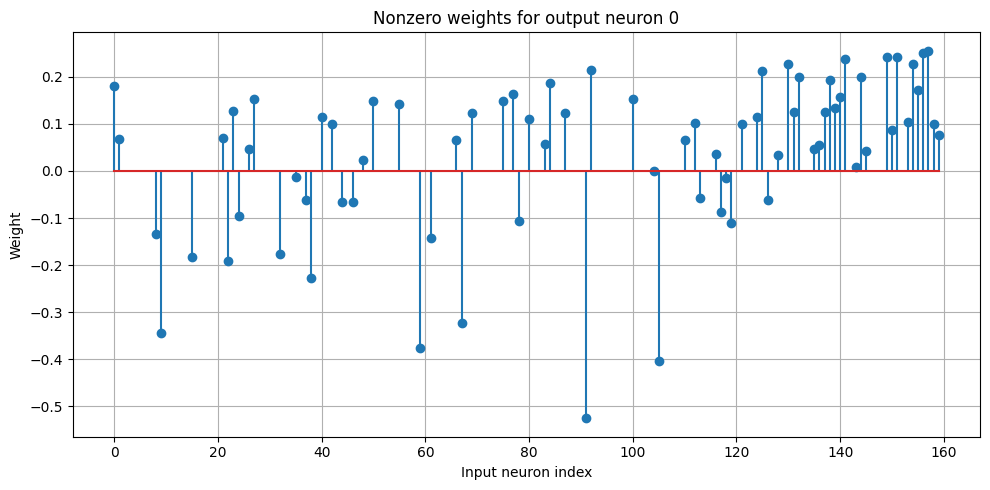

In [9]:
input_data = data_left_attleft[0]
output_data = data_att_attleft[0]

X, Y, most_active, _ = prep_data(input_data, output_data, firing_threshold = 0.01)

target_neuron = most_active[0]
y = Y[:, target_neuron]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = train_logistic_regression(X_train, y_train, C=0.1) 

accuracy = model.score(X_test, y_test)
print(f'Accuracy on test set for neuron {target_neuron}: {accuracy:.2f}')

spike_rate = np.mean(y_test)
print(f"Spike rate in test set: {spike_rate:.3f}")

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print(y_pred.shape)

weights = model.coef_[0]
nonzero = np.where(weights != 0)[0]

plt.figure(figsize=(10, 5))
plt.stem(nonzero, weights[nonzero])
plt.xlabel("Input neuron index")
plt.ylabel("Weight")
plt.title(f"Nonzero weights for output neuron {target_neuron}")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
y_proba = model.predict_proba(X_test)[:, 1]

for threshold in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]:
    y_pred_thresholded = (y_proba >= threshold).astype(int)
    print(f"Threshold: {threshold:.2f}")
    print(classification_report(y_test, y_pred_thresholded, digits=3))


Threshold: 0.90
              precision    recall  f1-score   support

         0.0      0.900     1.000     0.947     21051
         1.0      0.000     0.000     0.000      2349

    accuracy                          0.899     23400
   macro avg      0.450     0.500     0.474     23400
weighted avg      0.809     0.899     0.852     23400

Threshold: 0.80
              precision    recall  f1-score   support

         0.0      0.902     0.982     0.940     21051
         1.0      0.215     0.045     0.074      2349

    accuracy                          0.888     23400
   macro avg      0.558     0.513     0.507     23400
weighted avg      0.833     0.888     0.853     23400

Threshold: 0.70
              precision    recall  f1-score   support

         0.0      0.915     0.880     0.897     21051
         1.0      0.198     0.266     0.227      2349

    accuracy                          0.819     23400
   macro avg      0.557     0.573     0.562     23400
weighted avg      0.843   

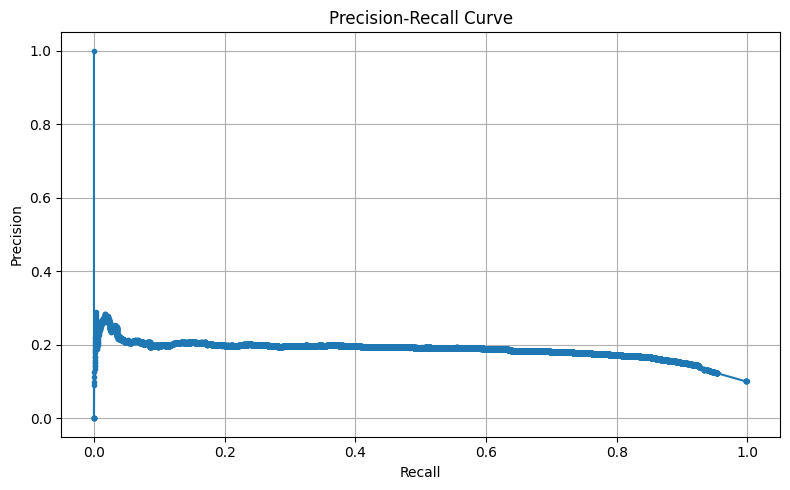

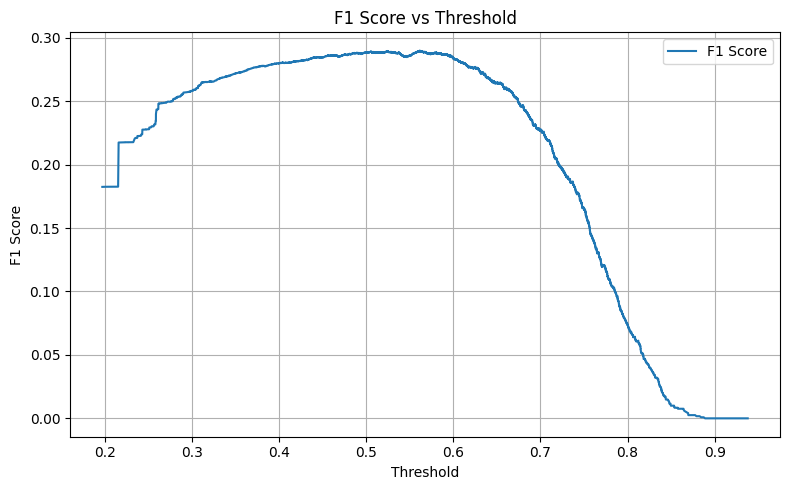

In [11]:
#finding predicted probabilities for class 1 (spike)
y_proba = model.predict_proba(X_test)[:, 1]

#computing precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.tight_layout()
plt.show()

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1],  label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




In [12]:
import numpy as np
from sklearn.metrics import f1_score

# Compute F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # add epsilon to avoid 0/0
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best F1 Score: {best_f1:.3f} at threshold = {best_threshold:.3f}")


Best F1 Score: 0.290 at threshold = 0.561


want at this point to change the structure: should really be training trial by trial with some history window, and updating the weights with subsequent trials. then will be able to give all neuron data for a single trial and predict the behaviour of a particular neuron - may be that some are particularly predictable   



In [13]:
def get_sample_weights(y):
    classes = np.array([0, 1])
    class_weights = compute_class_weight(class_weight = 'balanced', classes =  classes, y = y)
    weight_dict = dict(zip(classes, class_weights))
    sample_weights = np.array([weight_dict[label] for label in y])
    return sample_weights



In [14]:
def prep_trial_data(data_in, data_out, target_neuron, window_size = 10):
    #this will take a single trial of data
    time, n_in = data_in.shape
    X, y = [], []

    for t in range(window_size, time):   #this make sure you start at end of window 
        x = data_in[t-window_size:t, :].flatten()
        y_t = data_out[t, target_neuron]
        X.append(x)
        y.append(y_t)

    return np.array(X), np.array(y)

x_check, y_check = prep_trial_data(data_left_attleft[0][0], data_att_attleft[0][0], target_neuron, window_size = 10)
print(x_check.shape, y_check.shape)


#this will give n_times - window time samples (rows)
#and each row will have windown * neurons_in, e.g. each neuron gets 10 ticks of data




(490, 1600) (490,)


Number of test trials: 94
Accuracy on test set for neuron 0: 0.75
Spike rate in test set: 0.077
              precision    recall  f1-score   support

         0.0      0.967     0.753     0.847     42925
         1.0      0.191     0.695     0.299      3605

    accuracy                          0.748     46530
   macro avg      0.579     0.724     0.573     46530
weighted avg      0.907     0.748     0.804     46530

(46530,)


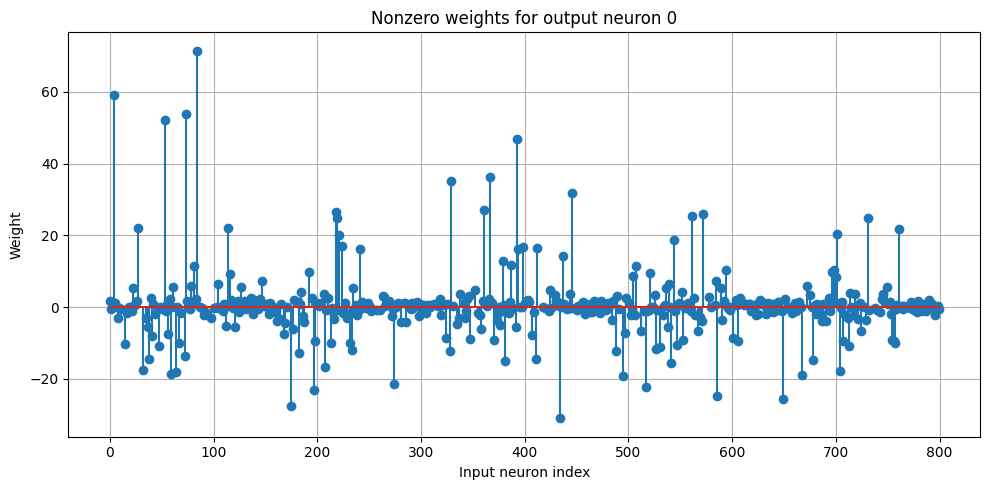

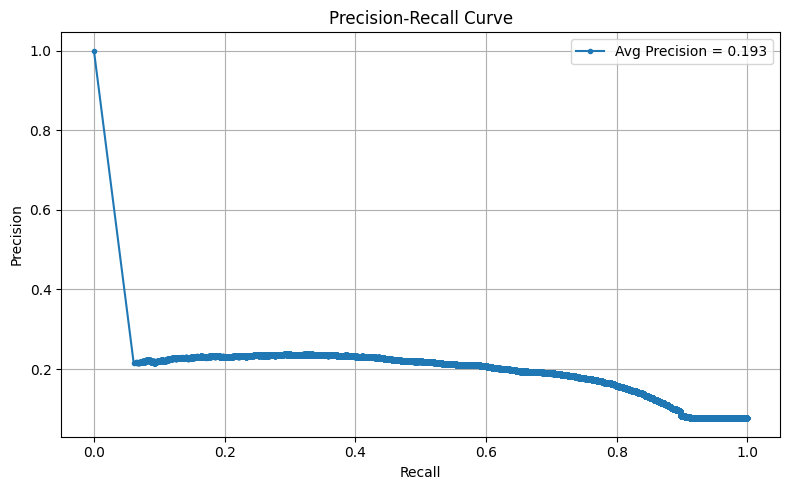

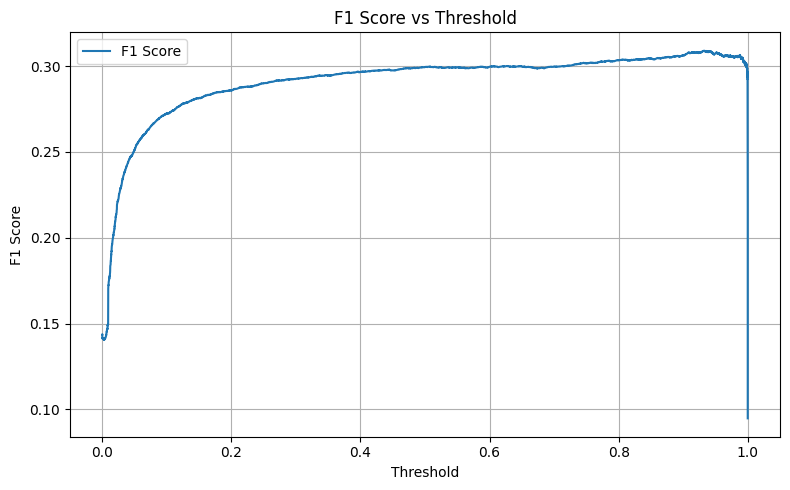

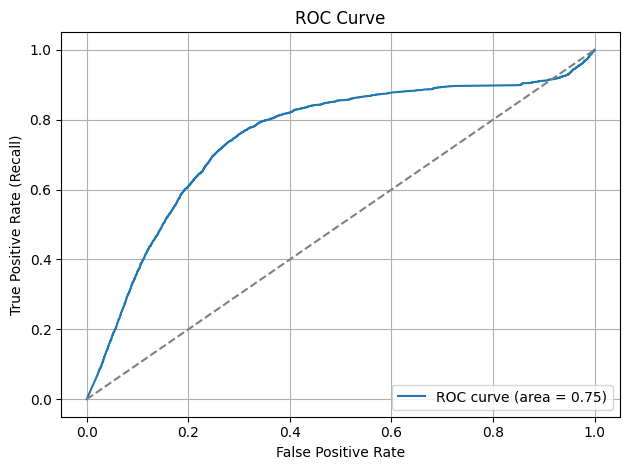

In [15]:
model = SGDClassifier(loss='log_loss', penalty='l1', learning_rate = 'optimal')

target_neuron = most_active[0]
n_trials = data_att_attleft[0].shape[0]

window_size = 5

for trial_idx in range(0, int(0.8 * n_trials)):
    input_trials = data_left_attleft[0][trial_idx]
    output_trials = data_att_attleft[0][trial_idx]

    X_trial, y_trial = prep_trial_data(input_trials, output_trials, target_neuron, window_size = window_size)
    sample_weights = get_sample_weights(y_trial)

    if trial_idx == 0 :
        model.partial_fit(X_trial, y_trial, classes=np.array([0, 1]), sample_weight=sample_weights)
    else:
        model.partial_fit(X_trial, y_trial ,sample_weight=sample_weights)



n_test_trials = n_trials - int(0.8 * n_trials)
print(f"Number of test trials: {n_test_trials}")

X_test, y_test = [], []
for trial_idx in range(int(0.8 * n_trials), n_trials):
    input_trials = data_left_attleft[0][trial_idx]
    output_trials = data_att_attleft[0][trial_idx]

    X_test_trial, y_test_trial = prep_trial_data(input_trials, output_trials, target_neuron, window_size = window_size)

    X_test.append(X_test_trial)
    y_test.append(y_test_trial)


X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)


accuracy = model.score(X_test, y_test)
print(f'Accuracy on test set for neuron {target_neuron}: {accuracy:.2f}')

spike_rate = np.mean(y_test)
print(f"Spike rate in test set: {spike_rate:.3f}")

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print(y_pred.shape)

weights = model.coef_[0]
nonzero = np.where(weights != 0)[0]

plt.figure(figsize=(10, 5))
plt.stem(nonzero, weights[nonzero])
plt.xlabel("Input neuron index")
plt.ylabel("Weight")
plt.title(f"Nonzero weights for output neuron {target_neuron}")
plt.grid(True)
plt.tight_layout()
plt.show()

#finding predicted probabilities for class 1 (spike)
y_proba = model.predict_proba(X_test)[:, 1]

#computing precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)


plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label = f'Avg Precision = {avg_prec:.3f}', marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1],  label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


X_vis shape: (495, 800), y_true shape: (495,)


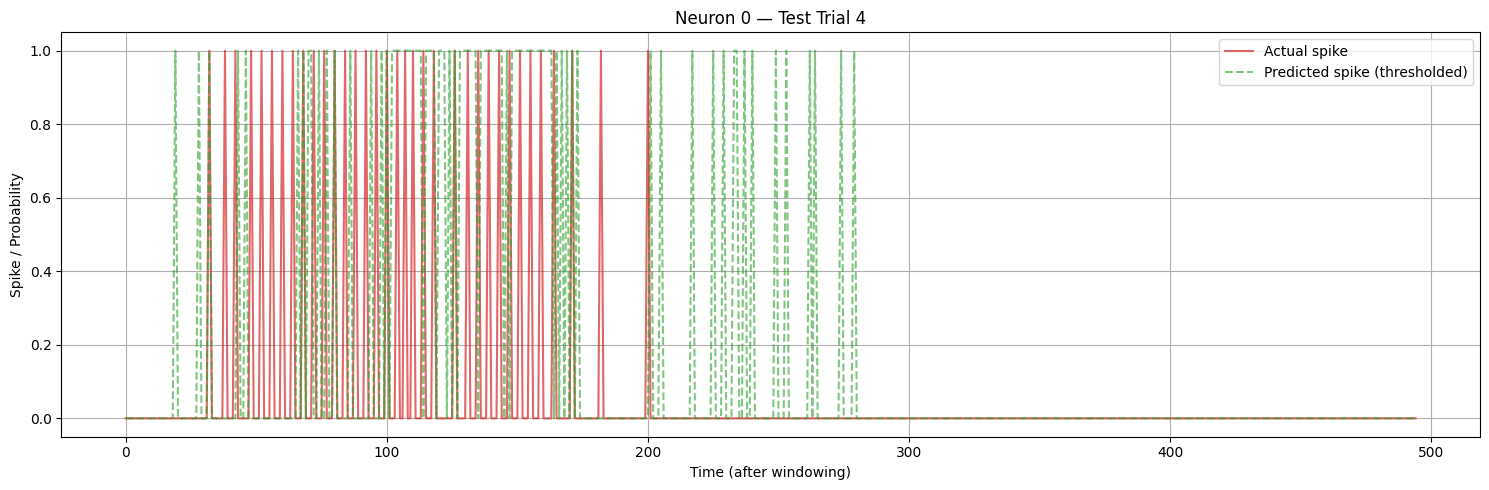

In [16]:
# --- Choose a single test trial to visualize ---
trial_idx = 4  # Index within test trials (0 = first test trial)
actual_trial_index = int(0.8 * n_trials) + trial_idx  # Convert to absolute index

# Load input/output data for this trial
input_trial = data_left_attleft[0][actual_trial_index]
output_trial = data_att_attleft[0][actual_trial_index]

# Prepare windowed data for the trial
X_vis, y_true = prep_trial_data(input_trial, output_trial, target_neuron, window_size=window_size)

print(f"X_vis shape: {X_vis.shape}, y_true shape: {y_true.shape}")
if X_vis.size == 0:
    raise ValueError("Trial windowed data is empty — something's wrong with the indexing or data.")

# Get predictions
y_pred_prob = model.predict_proba(X_vis)[:, 1]
y_pred_class = model.predict(X_vis)

# --- Plot ---
plt.figure(figsize=(15, 5))
#plt.plot(y_pred_prob, label='Predicted spike probability', color='tab:blue', alpha=0.9)
plt.plot(y_true, label='Actual spike', color='tab:red', alpha=0.7)
plt.plot(y_pred_class, label='Predicted spike (thresholded)', linestyle='--', color='tab:green', alpha=0.6)
plt.title(f"Neuron {target_neuron} — Test Trial {trial_idx}")
plt.xlabel('Time (after windowing)')
plt.ylabel('Spike / Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


the following retrains the model selecting for the neurons with the highest weight 

Top neurons by aggregated weight across time: [ 73 114  84  47   4  61  64  53   9  27  59  15  81  37 126  41  58  38
  91  92  32  67 121  72   8  56 105  78  74  50 117  22 104 116  17 109
  24  87 147 112]
Number of test trials: 94
Accuracy on test set for neuron 0: 0.86
Spike rate in test set: 0.077
              precision    recall  f1-score   support

         0.0      0.941     0.903     0.921     42925
         1.0      0.220     0.326     0.262      3605

    accuracy                          0.858     46530
   macro avg      0.580     0.614     0.592     46530
weighted avg      0.885     0.858     0.870     46530

(46530,)


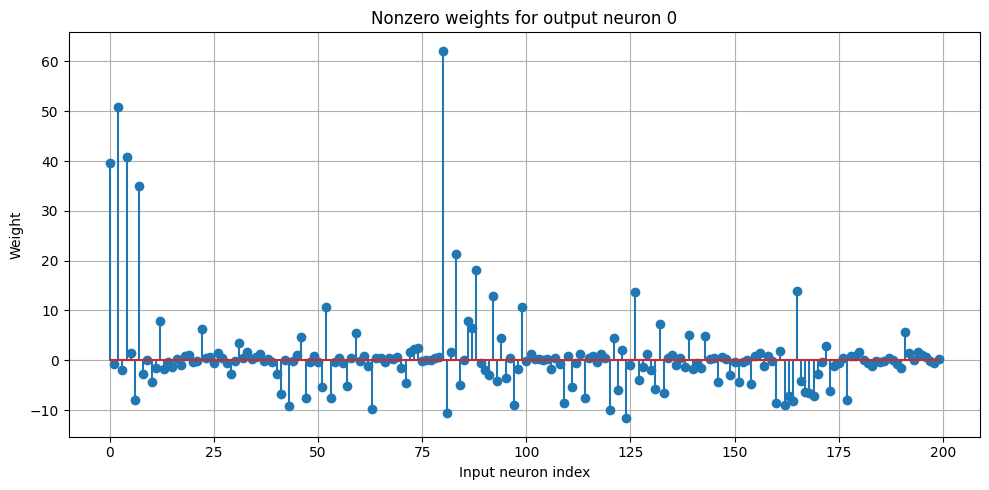

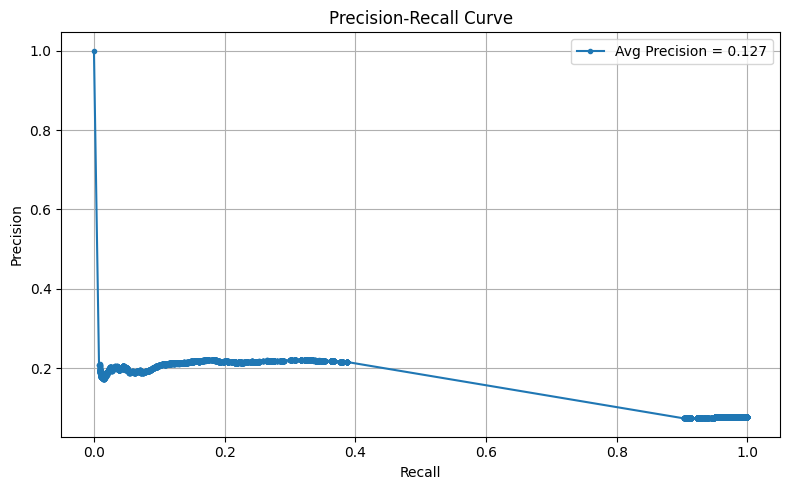

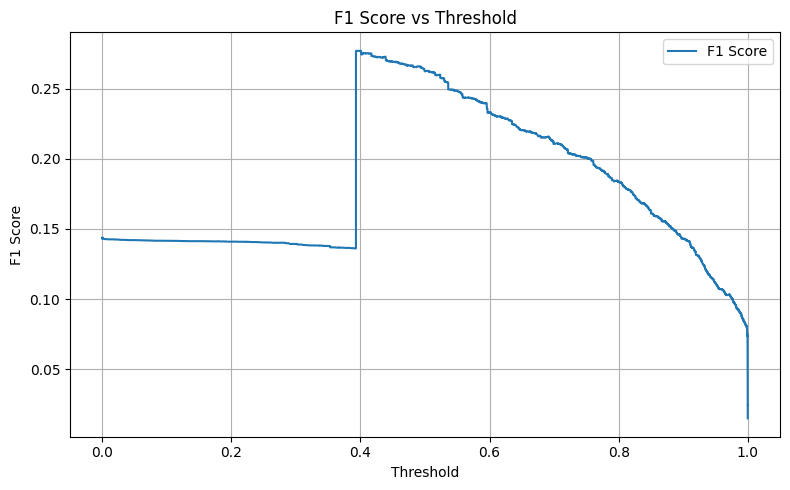

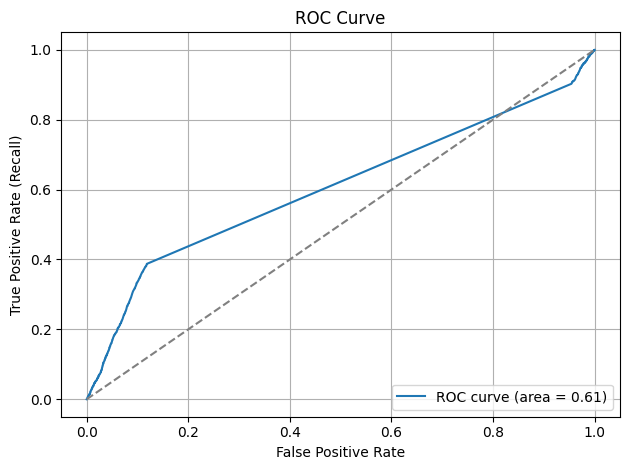

In [17]:
topN = 40

# Suppose your input feature shape is: (window_size × n_neurons)
n_neurons = 160
window_size = 5
feature_weights = np.abs(weights).reshape(window_size, n_neurons)

# Sum the absolute weights across time window for each neuron
neuron_scores = feature_weights.sum(axis=0)  # shape: (n_neurons,)
top_neuron_indices = np.argsort(neuron_scores)[::-1][:topN]
print("Top neurons by aggregated weight across time:", top_neuron_indices)

model = SGDClassifier(loss='log_loss', penalty='l1', learning_rate = 'optimal')

target_neuron = most_active[0]
n_trials = data_att_attleft[0].shape[0]

window_size = 5

for trial_idx in range(0, int(0.8 * n_trials)):
    input_trials = data_left_attleft[0][trial_idx][:, top_neuron_indices]
    output_trials = data_att_attleft[0][trial_idx]

    X_trial, y_trial = prep_trial_data(input_trials, output_trials, target_neuron, window_size = window_size)
    sample_weights = get_sample_weights(y_trial)

    if trial_idx == 0 :
        model.partial_fit(X_trial, y_trial, classes=np.array([0, 1]), sample_weight=sample_weights)
    else:
        model.partial_fit(X_trial, y_trial ,sample_weight=sample_weights)



n_test_trials = n_trials - int(0.8 * n_trials)
print(f"Number of test trials: {n_test_trials}")

X_test, y_test = [], []
for trial_idx in range(int(0.8 * n_trials), n_trials):
    input_trials = data_left_attleft[0][trial_idx][:, top_neuron_indices]
    output_trials = data_att_attleft[0][trial_idx]

    X_test_trial, y_test_trial = prep_trial_data(input_trials, output_trials, target_neuron, window_size = window_size)

    X_test.append(X_test_trial)
    y_test.append(y_test_trial)


X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)


accuracy = model.score(X_test, y_test)
print(f'Accuracy on test set for neuron {target_neuron}: {accuracy:.2f}')

spike_rate = np.mean(y_test)
print(f"Spike rate in test set: {spike_rate:.3f}")

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print(y_pred.shape)

weights = model.coef_[0]
nonzero = np.where(weights != 0)[0]

plt.figure(figsize=(10, 5))
plt.stem(nonzero, weights[nonzero])
plt.xlabel("Input neuron index")
plt.ylabel("Weight")
plt.title(f"Nonzero weights for output neuron {target_neuron}")
plt.grid(True)
plt.tight_layout()
plt.show()

#finding predicted probabilities for class 1 (spike)
y_proba = model.predict_proba(X_test)[:, 1]

#computing precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)


plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label = f'Avg Precision = {avg_prec:.3f}', marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1],  label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



retrain 10
      precision    recall  f1-score   support

         0.0      0.966     0.780     0.863     42925
         1.0      0.205     0.674     0.314      3605

    accuracy                          0.772     46530
   macro avg      0.585     0.727     0.589     46530
weighted avg      0.907     0.772     0.821     46530

retrain 40
Spike rate in test set: 0.077
              precision    recall  f1-score   support

         0.0      0.948     0.871     0.908     42925
         1.0      0.221     0.436     0.293      3605

    accuracy                          0.837     46530
   macro avg      0.585     0.653     0.601     46530
weighted avg      0.892     0.837     0.861     46530

vs previous

Accuracy on test set for neuron 0: 0.73
Spike rate in test set: 0.077
              precision    recall  f1-score   support

         0.0      0.964     0.739     0.836     42925
         1.0      0.177     0.667     0.279      3605

    accuracy                          0.733     46530
   macro avg      0.570     0.703     0.558     46530
weighted avg      0.903     0.733     0.793     46530



In [18]:

target_neurons = np.arange(0, 80)
n_trials = data_att_attleft[0].shape[0]
window_size = 5

f1_scores = []
spike_rates = []
accuracies = []
skipped_neurons = []

for target_neuron in target_neurons:
    model = SGDClassifier(loss='log_loss', penalty='l1', learning_rate='optimal')
    first_fit = True

    for trial_idx in range(0, int(0.8 * n_trials)):
        input_trials = data_left_attleft[0][trial_idx]
        output_trials = data_att_attleft[0][trial_idx]

        X_trial, y_trial = prep_trial_data(input_trials, output_trials, target_neuron, window_size=window_size)

        if len(np.unique(y_trial)) < 2:
            continue

        sample_weights = get_sample_weights(y_trial)

        if first_fit:
            model.partial_fit(X_trial, y_trial, classes=np.array([0, 1]), sample_weight=sample_weights)
            first_fit = False
        else:
            model.partial_fit(X_trial, y_trial, sample_weight=sample_weights)

    #skip evaluation if model was never trained
    if first_fit:
        print(f"Skipping neuron {target_neuron} — no valid training data.")
        skipped_neurons.append(target_neuron)
        continue


    X_test, y_test = [], []
    for trial_idx in range(int(0.8 * n_trials), n_trials):
        input_trials = data_left_attleft[0][trial_idx]
        output_trials = data_att_attleft[0][trial_idx]

        X_test_trial, y_test_trial = prep_trial_data(input_trials, output_trials, target_neuron, window_size=window_size)

        X_test.append(X_test_trial)
        y_test.append(y_test_trial)

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    accuracy = model.score(X_test, y_test)
    print(f'Accuracy on test set for neuron {target_neuron}: {accuracy:.2f}')
    accuracies.append(accuracy)

    spike_rate = np.mean(y_test)
    print(f"Spike rate in test set: {spike_rate:.3f}")
    spike_rates.append(spike_rate)

    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)
    f1 = report['1.0']['f1-score']
    f1_scores.append(f1)

    print(f'Completed neuron {target_neuron}')

# Number of test trials: 94
# Accuracy on test set for neuron 0: 0.83
# Spike rate in test set: 0.077
# {'0.0': {'precision': 0.9454545454545454, 'recall': 0.861316249271986, 'f1-score': 0.9014263074484945, 'support': 42925.0},
#   '1.0': {'precision': 0.19824915824915826, 'recall': 0.4083217753120666, 'f1-score': 0.2669084315503173, 'support': 3605.0}, 
  
#   'accuracy': 0.8262196432409198,
#  'macro avg': {'precision': 0.5718518518518518, 'recall': 0.6348190122920263, 'f1-score': 0.5841673694994058, 'support': 46530.0}, 
#   'weighted avg': {'precision': 0.8875633909117683, 'recall': 0.8262196432409198, 'f1-score': 0.8522658315702885, 'support': 46530.0}}
   
# Generate x-axis labels (neuron indices)
processed_neurons = np.setdiff1d(target_neurons, skipped_neurons)

# Make sure this matches the order you plotted
processed_neurons = np.setdiff1d(target_neurons, skipped_neurons)

# Find index of best F1 score
best_idx = np.argmax(f1_scores)
best_neuron = processed_neurons[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best F1 score is {best_f1:.3f} for neuron {best_neuron}")



Accuracy on test set for neuron 0: 0.64
Spike rate in test set: 0.077
Completed neuron 0
Accuracy on test set for neuron 1: 0.87
Spike rate in test set: 0.010
Completed neuron 1
Accuracy on test set for neuron 2: 0.68
Spike rate in test set: 0.083
Completed neuron 2
Accuracy on test set for neuron 3: 0.63
Spike rate in test set: 0.002
Completed neuron 3
Skipping neuron 4 — no valid training data.
Skipping neuron 5 — no valid training data.
Accuracy on test set for neuron 6: 0.81
Spike rate in test set: 0.057
Completed neuron 6
Accuracy on test set for neuron 7: 0.73
Spike rate in test set: 0.011
Completed neuron 7
Accuracy on test set for neuron 8: 0.80
Spike rate in test set: 0.187
Completed neuron 8
Skipping neuron 9 — no valid training data.
Accuracy on test set for neuron 10: 0.79
Spike rate in test set: 0.011
Completed neuron 10
Accuracy on test set for neuron 11: 0.81
Spike rate in test set: 0.003
Completed neuron 11
Accuracy on test set for neuron 12: 0.71
Spike rate in test set

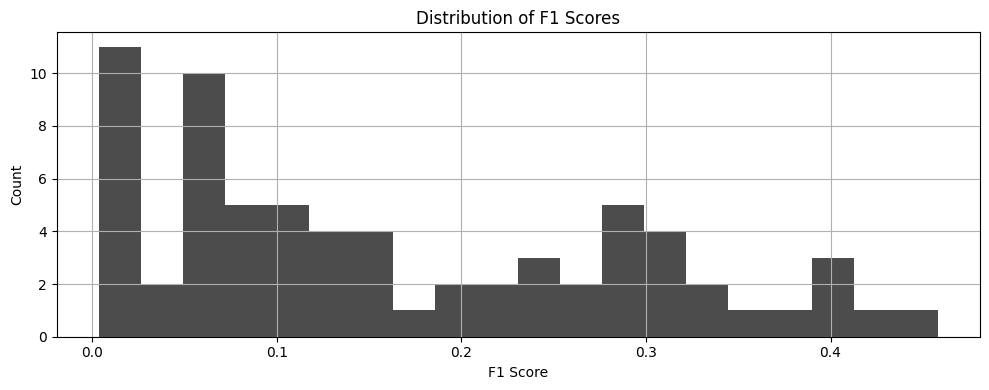

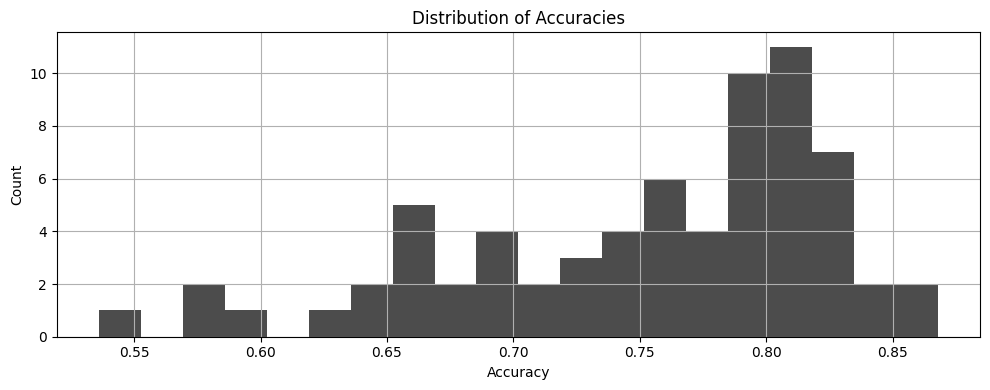

In [19]:
#plotting histograms for the f1 scores
plt.figure(figsize=(10, 4))
plt.hist(f1_scores, bins=20, color='black', alpha=0.7)
plt.xlabel("F1 Score")
plt.ylabel("Count")
plt.title("Distribution of F1 Scores")
plt.grid(True)
plt.tight_layout()
plt.show()

#finding neurong with best f1 score

#plotting histograms for the accuracies
plt.figure(figsize=(10, 4))
plt.hist(accuracies, bins=20, color='black', alpha=0.7)
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.title("Distribution of Accuracies")
plt.grid(True)
plt.tight_layout()
plt.show()




Number of test trials: 94
Accuracy on test set for neuron 28: 0.74
Spike rate in test set: 0.150
              precision    recall  f1-score   support

         0.0      0.954     0.723     0.823     39569
         1.0      0.338     0.802     0.475      6961

    accuracy                          0.735     46530
   macro avg      0.646     0.763     0.649     46530
weighted avg      0.862     0.735     0.771     46530

(46530,)


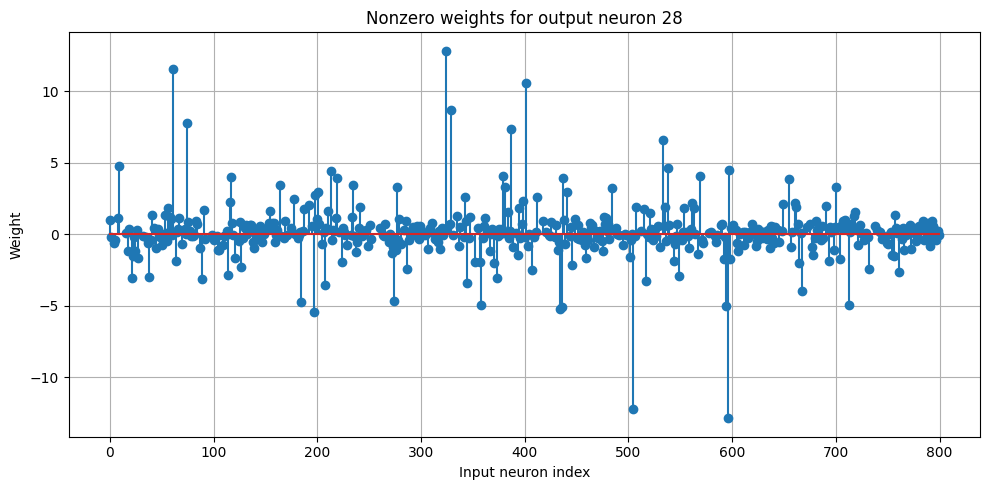

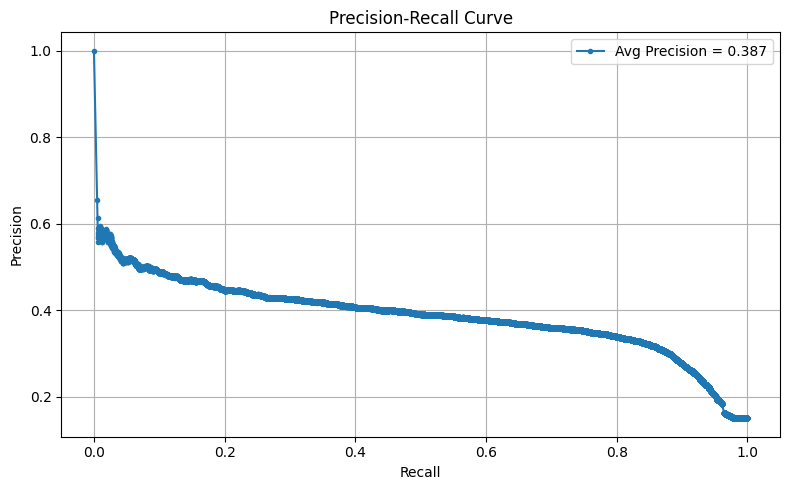

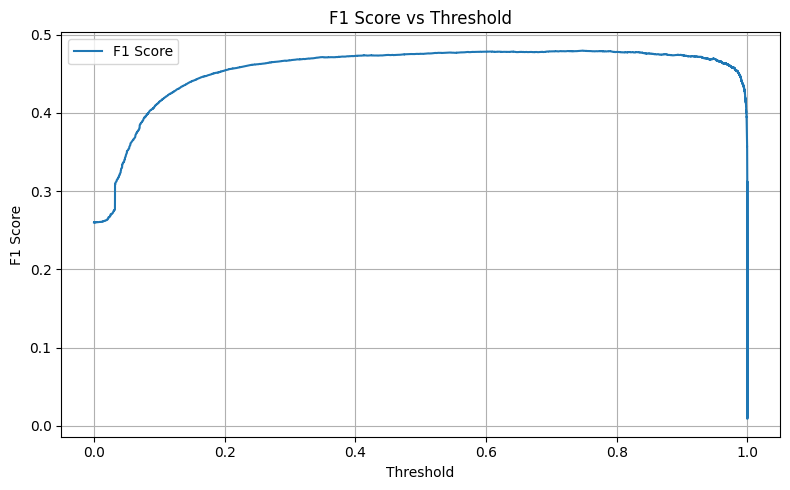

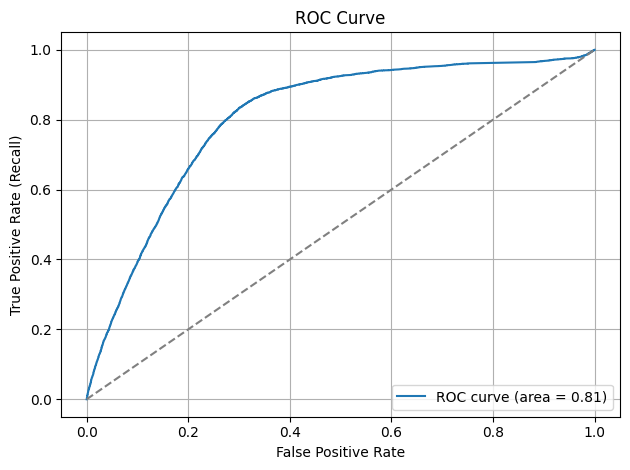

In [21]:
model = SGDClassifier(loss='log_loss', penalty='l1', learning_rate = 'optimal')

target_neuron = 28
n_trials = data_att_attleft[0].shape[0]

window_size = 5

for trial_idx in range(0, int(0.8 * n_trials)):
    input_trials = data_left_attleft[0][trial_idx]
    output_trials = data_att_attleft[0][trial_idx]

    X_trial, y_trial = prep_trial_data(input_trials, output_trials, target_neuron, window_size = window_size)
    sample_weights = get_sample_weights(y_trial)

    if trial_idx == 0 :
        model.partial_fit(X_trial, y_trial, classes=np.array([0, 1]), sample_weight=sample_weights)
    else:
        model.partial_fit(X_trial, y_trial ,sample_weight=sample_weights)



n_test_trials = n_trials - int(0.8 * n_trials)
print(f"Number of test trials: {n_test_trials}")

X_test, y_test = [], []
for trial_idx in range(int(0.8 * n_trials), n_trials):
    input_trials = data_left_attleft[0][trial_idx]
    output_trials = data_att_attleft[0][trial_idx]

    X_test_trial, y_test_trial = prep_trial_data(input_trials, output_trials, target_neuron, window_size = window_size)

    X_test.append(X_test_trial)
    y_test.append(y_test_trial)


X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)


accuracy = model.score(X_test, y_test)
print(f'Accuracy on test set for neuron {target_neuron}: {accuracy:.2f}')

spike_rate = np.mean(y_test)
print(f"Spike rate in test set: {spike_rate:.3f}")

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print(y_pred.shape)

weights = model.coef_[0]
nonzero = np.where(weights != 0)[0]

plt.figure(figsize=(10, 5))
plt.stem(nonzero, weights[nonzero])
plt.xlabel("Input neuron index")
plt.ylabel("Weight")
plt.title(f"Nonzero weights for output neuron {target_neuron}")
plt.grid(True)
plt.tight_layout()
plt.show()

#finding predicted probabilities for class 1 (spike)
y_proba = model.predict_proba(X_test)[:, 1]

#computing precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)


plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label = f'Avg Precision = {avg_prec:.3f}', marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_score[:-1],  label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


X_vis shape: (495, 800), y_true shape: (495,)


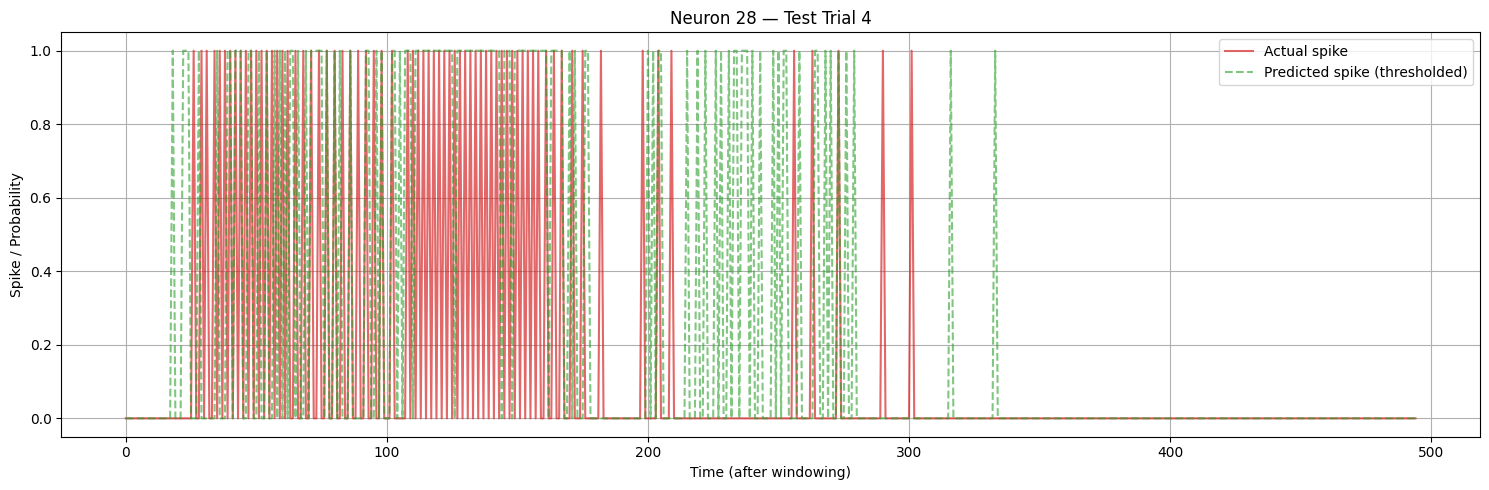

In [ ]:
trial_idx = 4
actual_trial_index = int(0.8 * n_trials) + trial_idx  # Convert to absolute index

#input/output data for this trial
input_trial = data_left_attleft[0][actual_trial_index]
output_trial = data_att_attleft[0][actual_trial_index]

#windowed data for the trial
X_vis, y_true = prep_trial_data(input_trial, output_trial, target_neuron, window_size=window_size)

print(f"X_vis shape: {X_vis.shape}, y_true shape: {y_true.shape}")
if X_vis.size == 0:
    raise ValueError("Trial windowed data is empty — something's wrong with the indexing or data.")

#predictions
y_pred_prob = model.predict_proba(X_vis)[:, 1]
y_pred_class = model.predict(X_vis)

# --- Plot ---
plt.figure(figsize=(15, 5))
#plt.plot(y_pred_prob, label='Predicted spike probability', color='tab:blue', alpha=0.9)
plt.plot(y_true, label='Actual spike', color='tab:red', alpha=0.7)
plt.plot(y_pred_class, label='Predicted spike (thresholded)', linestyle='--', color='tab:green', alpha=0.6)
plt.title(f"Neuron {target_neuron} — Test Trial {trial_idx}")
plt.xlabel('Time (after windowing)')
plt.ylabel('Spike / Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



try MVPA - should help in reducing dimensionality without losing info

try the coherence now with the coherence 